# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import math

import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torchvision import datasets, transforms

# Importing our existing flow funcs
import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
# Import modules
from analytic_flow_funcs import compute_linear_velocity_batch, forward_euler_integration_analytic_linear, compute_predictions
from image_display_funcs import (plot_labelled_images, plot_image, visualize_image_trajectory, 
                                image_trajectory_animation, find_closest_matches, display_comparisons, plot_save_image)

os.makedirs("results", exist_ok=True)

# Set device (automatically detects GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Load and Display MNIST

Class counts: {0: 4932, 1: 5678, 2: 4968, 3: 5101, 4: 4859, 5: 4506, 6: 4951, 7: 5175, 8: 4842, 9: 4988}
MNIST subset shape: torch.Size([50000, 1, 28, 28])
Noise samples shape: torch.Size([5, 1, 28, 28])


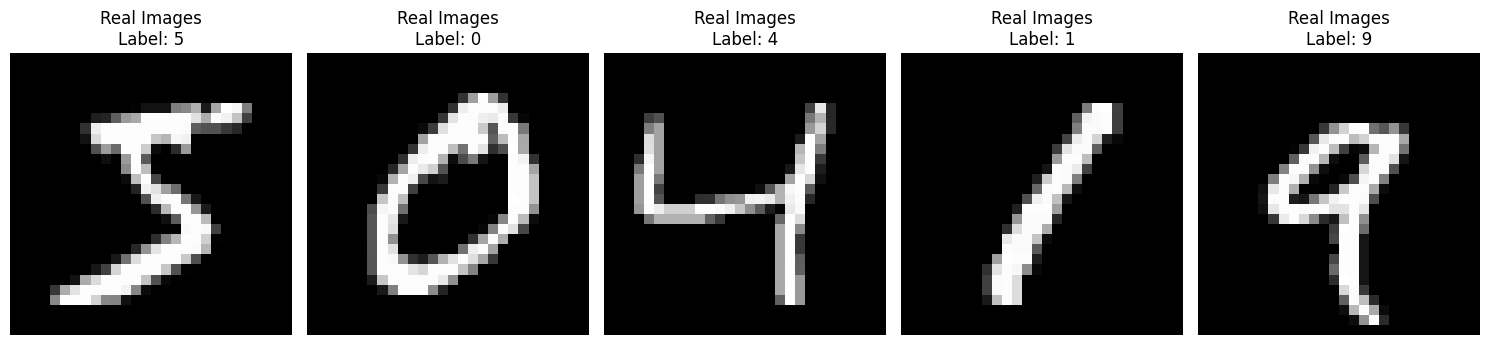

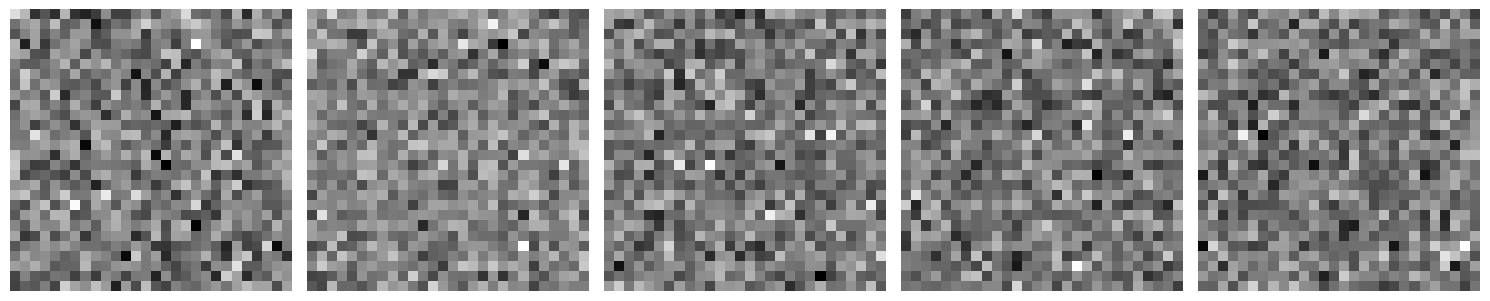

In [2]:
# 1. Load MNIST subset (first 1000 images)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
subset = torch.utils.data.Subset(mnist_train, range(50000))  # Use the first N samples

# Get labels via original dataset's targets
labels = mnist_train.targets[subset.indices]

# Display class distribution
unique, counts = torch.unique(labels, return_counts=True)
print("Class counts:", dict(zip(unique.numpy(), counts.numpy())))

# Create DataLoader and move to device
dataloader = torch.utils.data.DataLoader(subset, batch_size=len(subset))
images, labels = next(iter(dataloader))
images, labels = images.to(device), labels.to(device)

# Generate Gaussian noise samples (same shape as MNIST)
num_noise_samples = 5
image_shape = images[0].shape 
noise_samples = torch.randn(size=(num_noise_samples, *image_shape),  # [5, 3, 224, 224]
                    device=device)

# Display results
print(f"MNIST subset shape: {images.shape}")  # [1000, 1, 28, 28] on device
print(f"Noise samples shape: {noise_samples.shape}")  # [4, 1, 28, 28] on same device

plot_labelled_images(images, n_samples = 5, title="Real Images", labels = labels)
plot_image(noise_samples, n_samples = 5)

# Analytic Flow-Matching

In [3]:
# Run integration
start_time = time.time()
num_steps = 50

trajectory = forward_euler_integration_analytic_linear(
    initial_points=noise_samples,
    data=images,
    t_start=0.0,
    t_end=1.0, 
    num_steps=num_steps,
    sigma_i=1.0
)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Integration completed in {elapsed_time:.4f} seconds")

Integration completed in 0.2892 seconds


# Visualizations

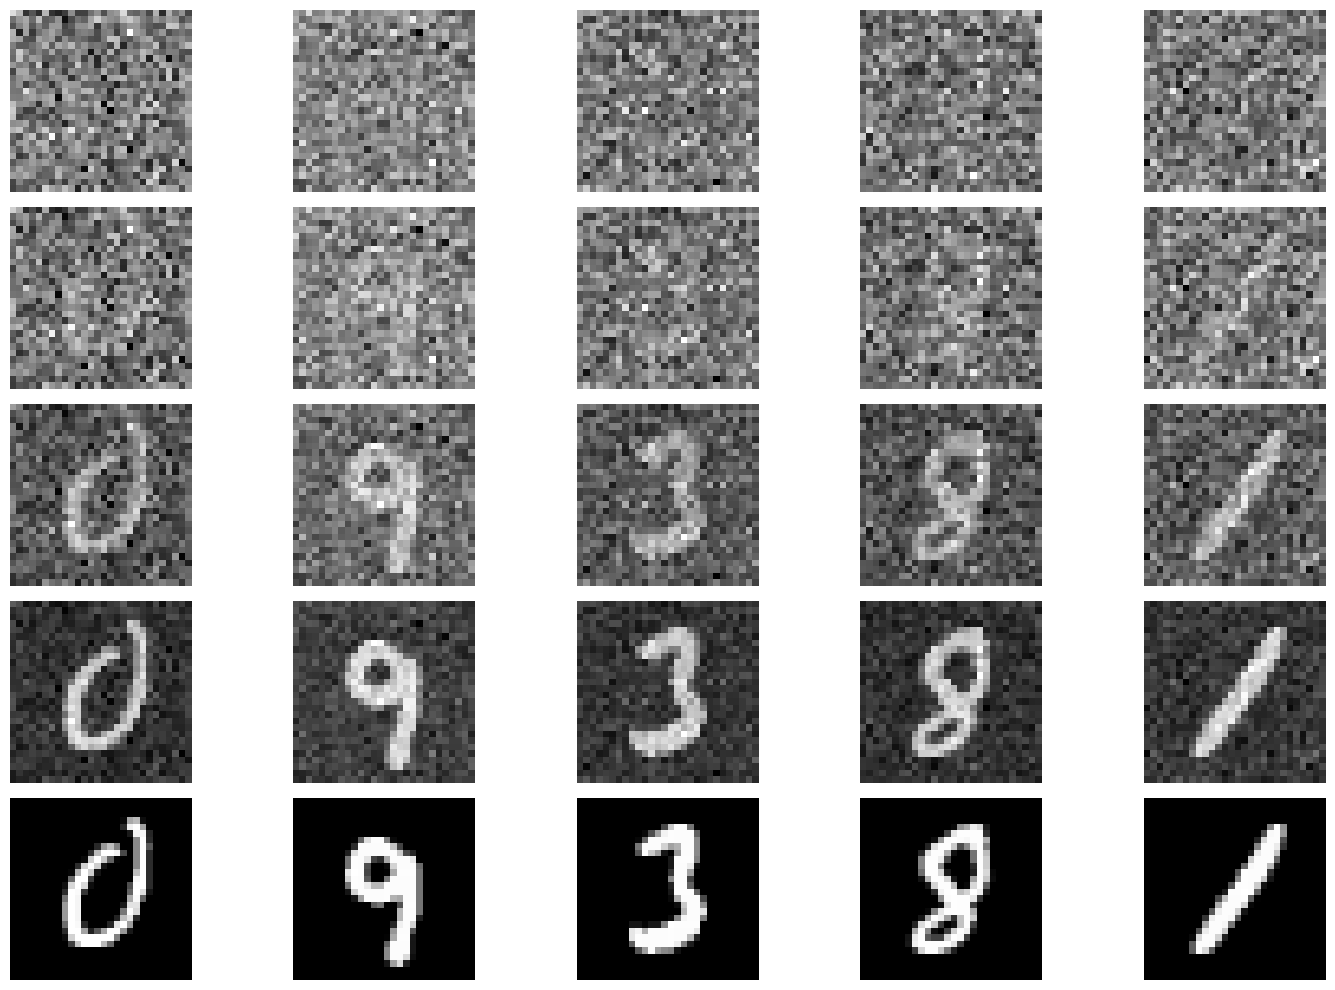

In [4]:
visualize_image_trajectory(trajectory, num_time_points=5)

In [5]:
ani = image_trajectory_animation(trajectory)
ani.save('results/mnist_analytic_denoising.gif', writer='pillow', fps=20, dpi=80)

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(ani.to_jshtml())

# Visualizing Predictions Over Time

Our analytical formula has the nice intepretation of our model generating a final prediction at each time point, which becomes more refined. We can plot it's prediction over time to see how quickly our model hones in on a specific image.

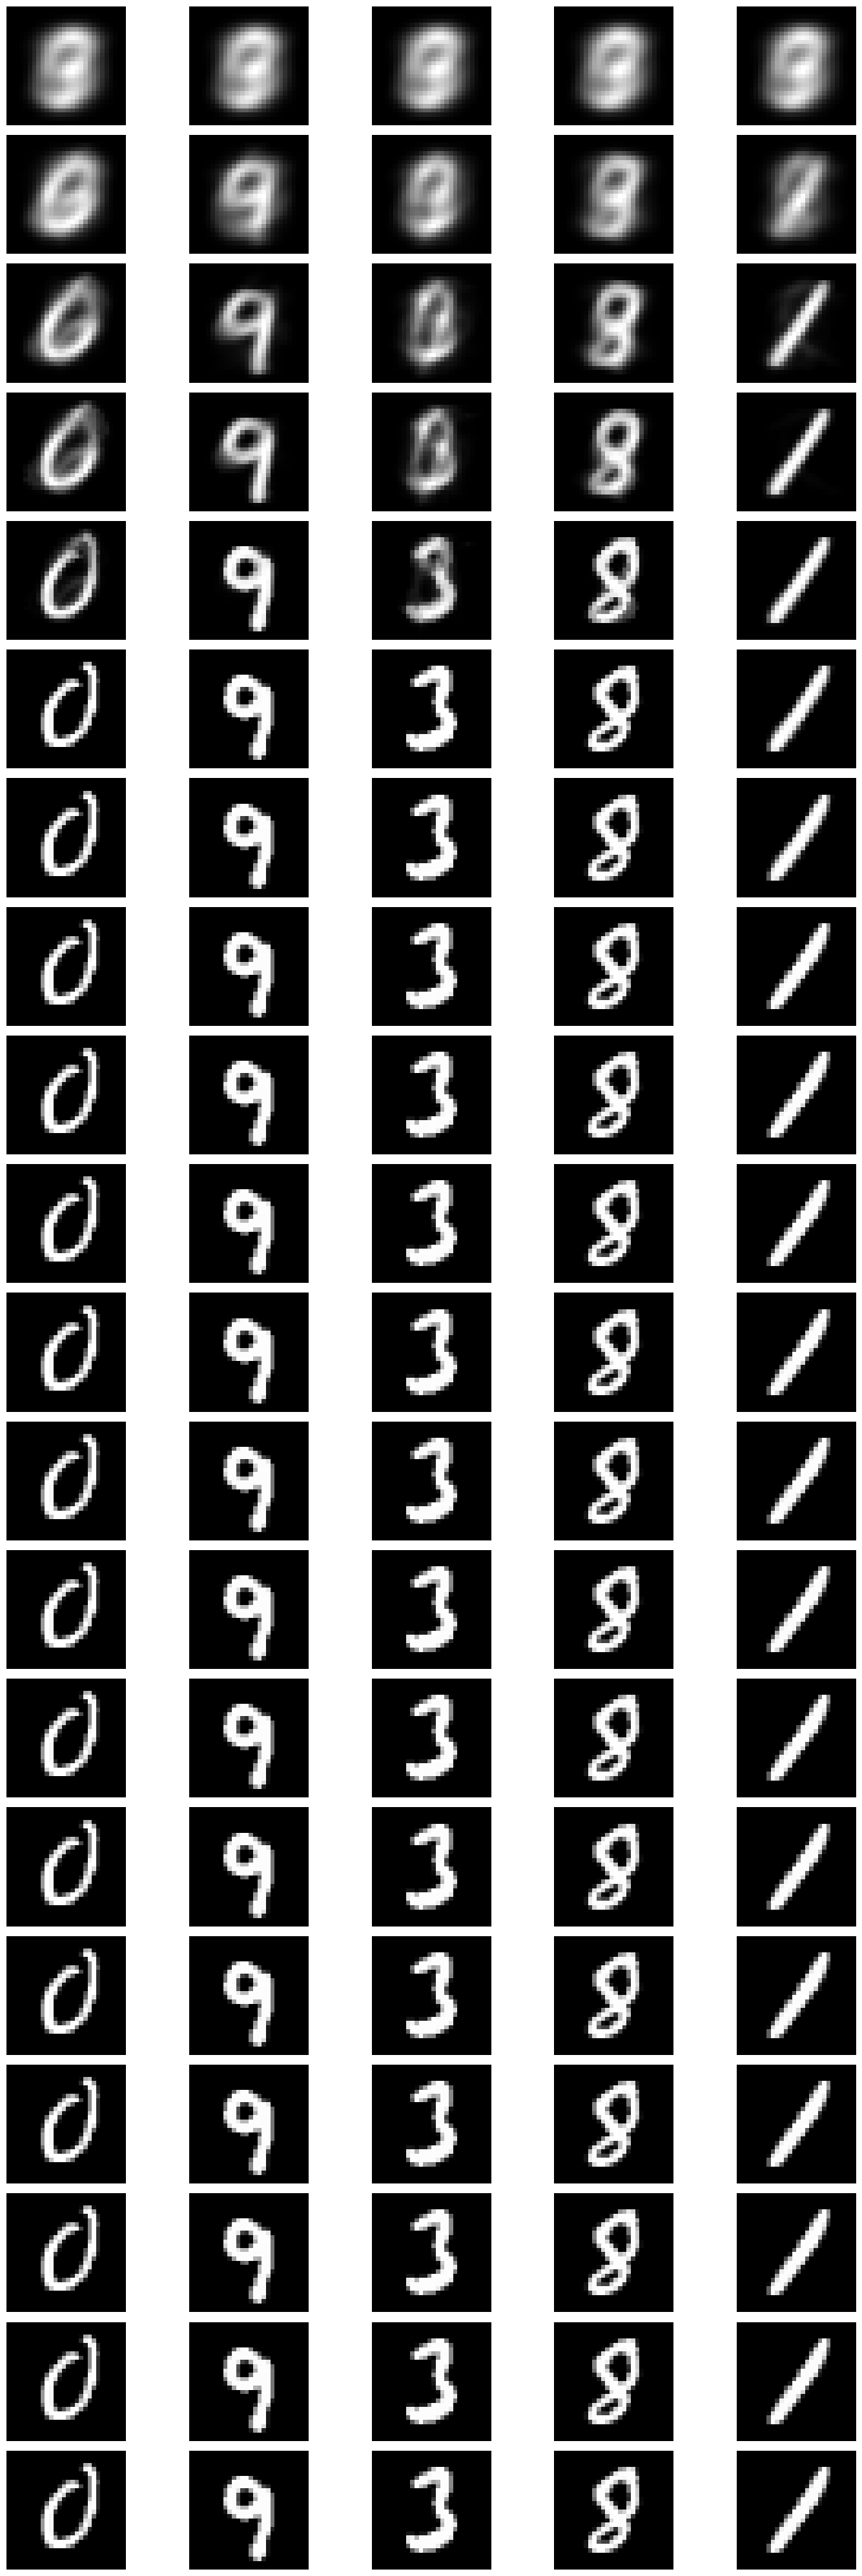

In [6]:
predictions = compute_predictions(trajectory, num_steps=num_steps)
visualize_image_trajectory(predictions, num_time_points=min(num_steps, 20))  # Show time points

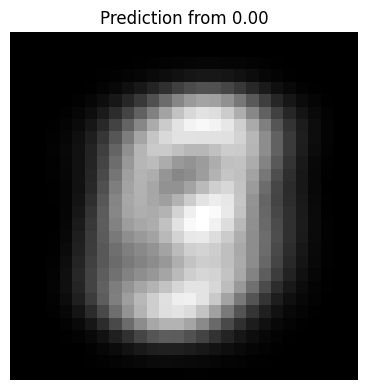

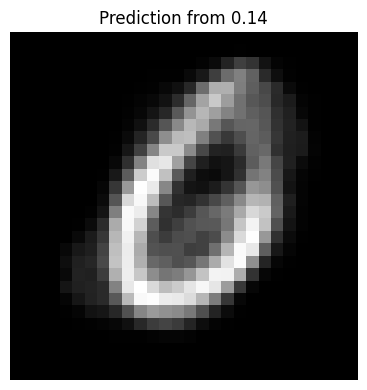

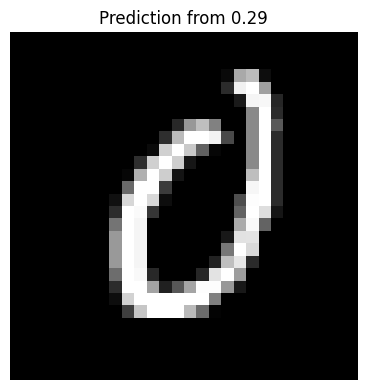

In [7]:
image = predictions[0, 0]
time_value = 0
filename = f'results/MNIST_at_{time_value:.2f}.png'
title = f'Prediction from {time_value:.2f}'
plot_save_image(image, figsize=(4, 4), filename=filename, title=title)

x = (int)(0.15*num_steps)
image = predictions[x, 0]
time_value = x/len(predictions)
filename = f'results/MNIST_at_{time_value:.2f}.png'
title = f'Prediction from {time_value:.2f}'
plot_save_image(image, figsize=(4, 4), filename=filename, title=title)

x = (int)(0.3*num_steps)
image = predictions[x, 0]
time_value = x/len(predictions)
filename = f'results/MNIST_at_{time_value:.2f}.png'
title = f'Prediction from {time_value:.2f}'
plot_save_image(image, figsize=(4, 4), filename=filename, title=title)

# Checking For Matching Images

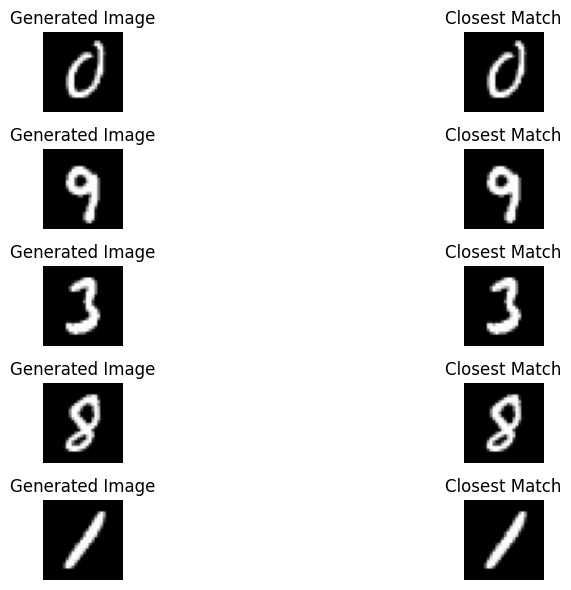

In [8]:
# Get final images from trajectory
generated_images = trajectory[-1] 

min_mses, closest_indices = find_closest_matches(
    generated_images, images, device = device)

# Display comparisons
display_comparisons(generated_images, images, 
                   closest_indices,
                   num_display=5,
                    filename="results/analytic_comparison.png")

# Fixed Seed Noise

In [9]:
# Set fixed seed for reproducibility
seed = 4
torch.manual_seed(seed)

# Generate noise samples
num_noise_samples = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_samples = torch.randn(size=(num_noise_samples, 1, 28, 28),
                          device=device)

# Create directory if it doesn't exist
os.makedirs('saved_samples', exist_ok=True)

# Save both the samples and the seed
torch.save({
    'seed': seed,
    'noise_samples': noise_samples.cpu()  # Move to CPU before saving
}, 'saved_samples/noise_samples.pt')

print(f"Saved {num_noise_samples} noise samples with seed {seed}")

Saved 5 noise samples with seed 4


In [10]:
# Load the saved data
saved_data = torch.load('saved_samples/noise_samples.pt')

# Extract components
seed = saved_data['seed']
noise_samples = saved_data['noise_samples']
noise_samples = noise_samples.to(device)

print(f"Loaded {len(noise_samples)} samples generated with seed {seed}")

Loaded 5 samples generated with seed 4


Noise samples shape: torch.Size([5, 1, 28, 28])


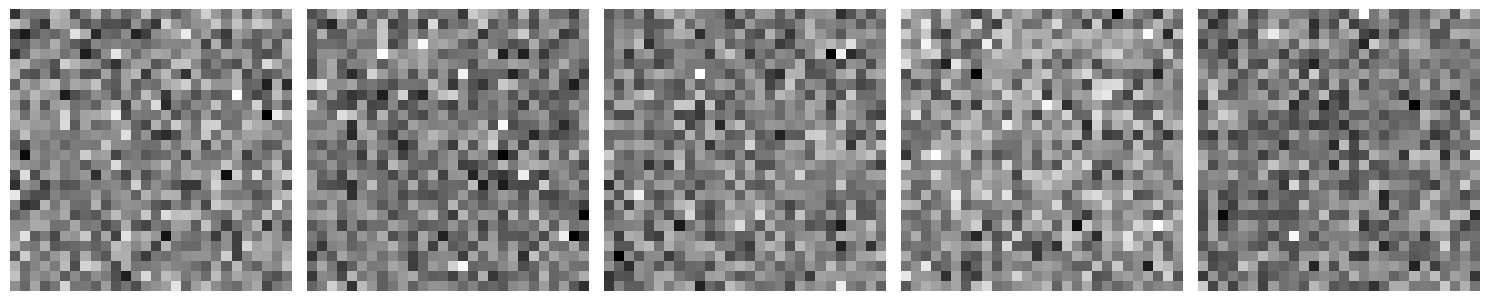

In [11]:
print(f"Noise samples shape: {noise_samples.shape}")  # [4, 1, 28, 28] on same device
plot_image(noise_samples, n_samples = 5)

In [12]:
# Run integration
start_time = time.time()
num_steps = 50

trajectory = forward_euler_integration_analytic_linear(
    initial_points=noise_samples,
    data=images,
    t_start=0.0,
    t_end=1.0, 
    num_steps=num_steps,
    sigma_i=1.0
)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Integration completed in {elapsed_time:.4f} seconds")

Integration completed in 0.0307 seconds


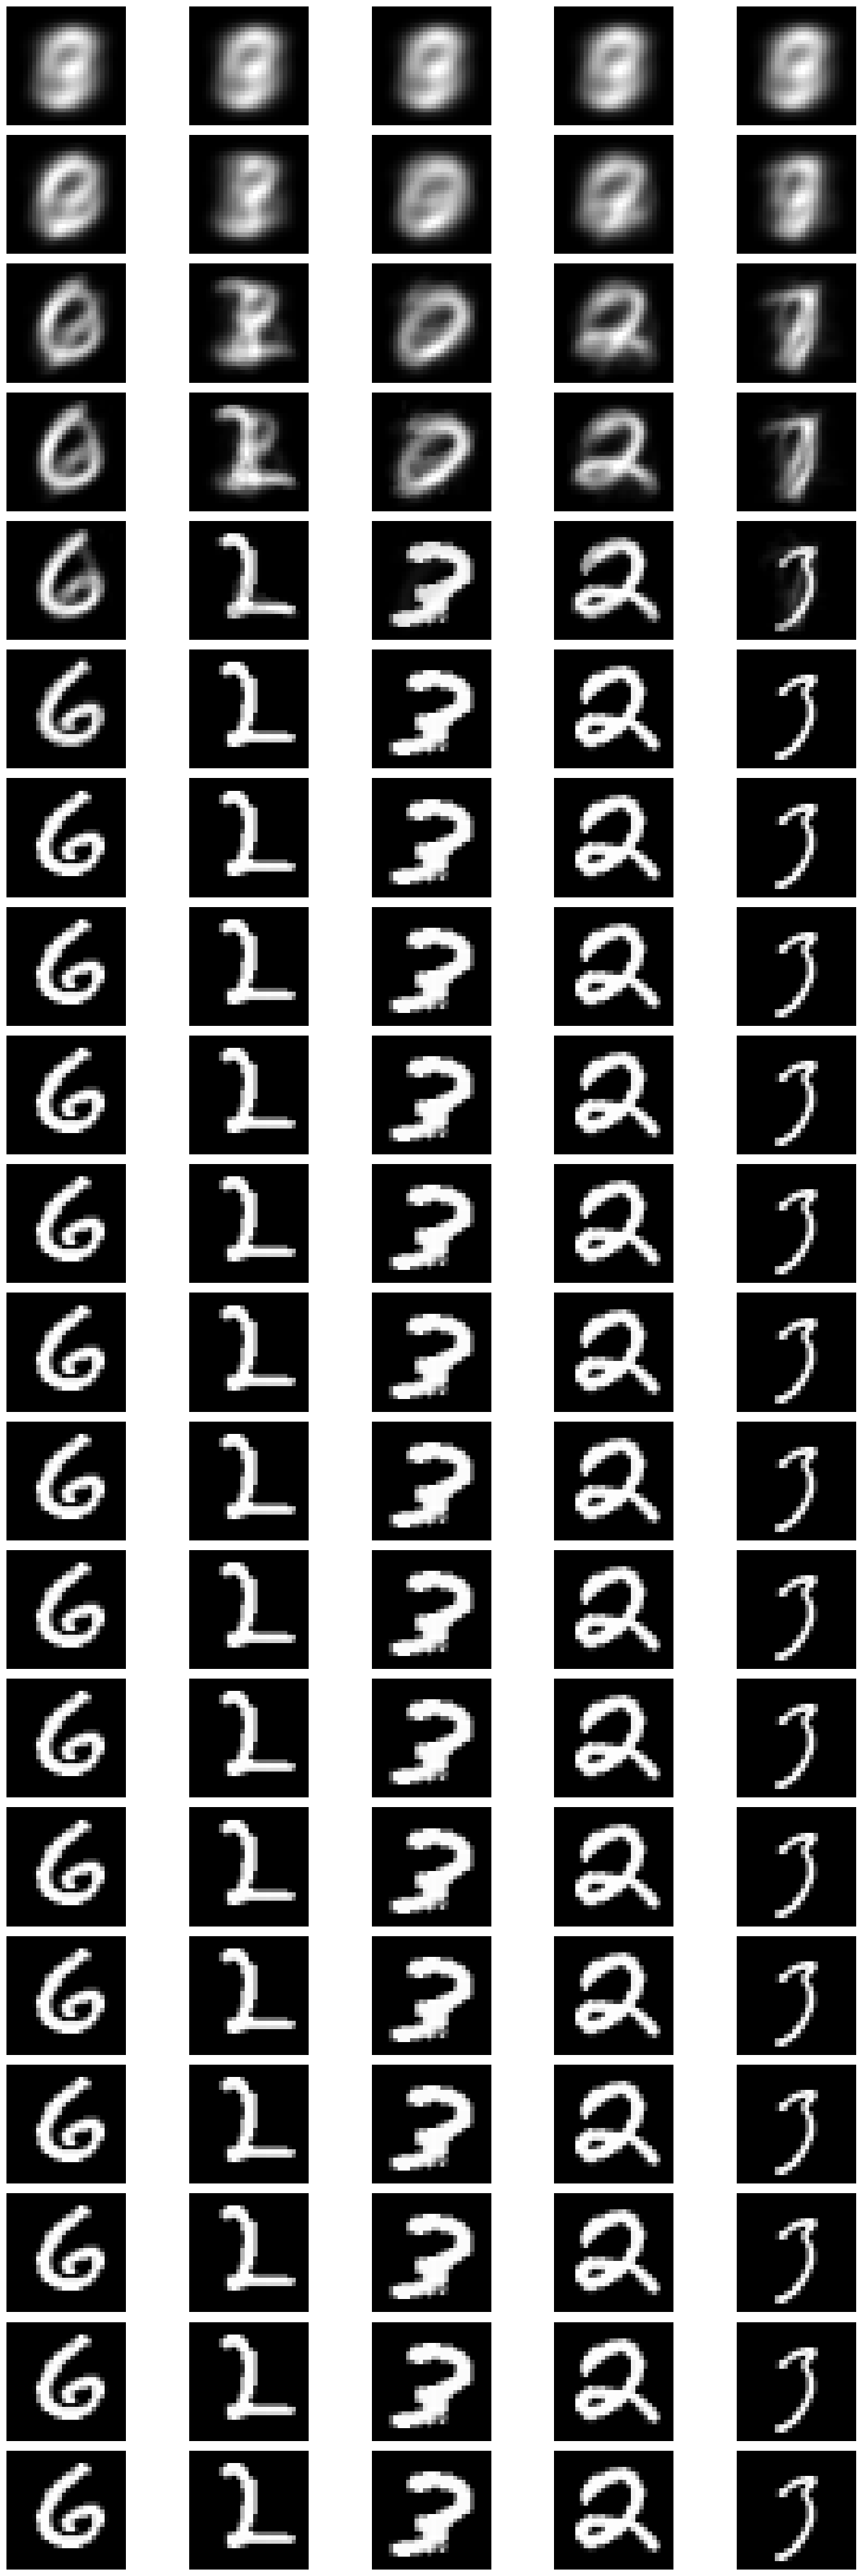

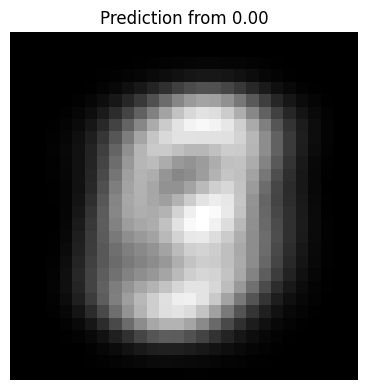

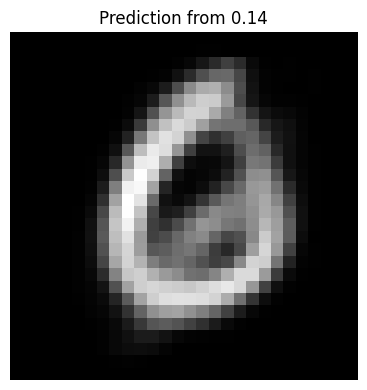

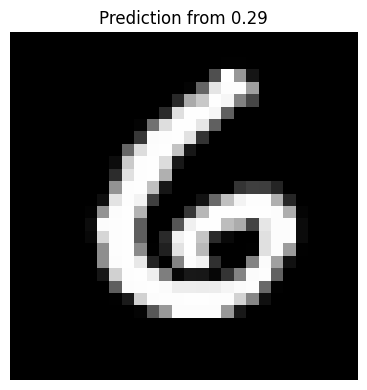

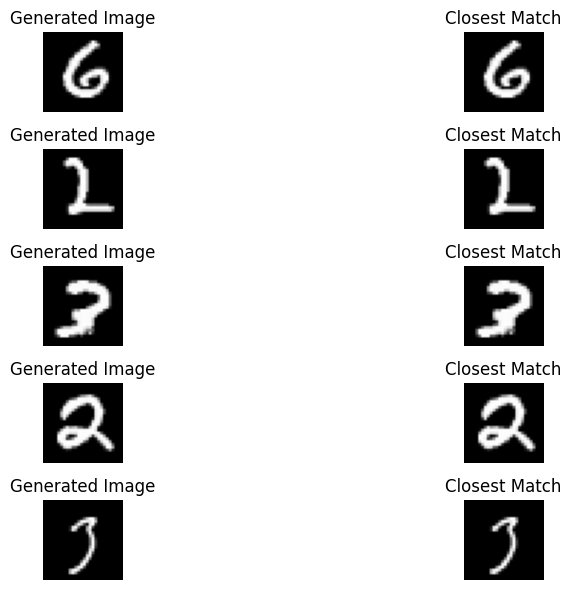

In [15]:
predictions = compute_predictions(trajectory, num_steps=num_steps)
visualize_image_trajectory(predictions, num_time_points=min(num_steps, 20))  # Show time points
generated_images = trajectory[-1]

image = predictions[0, 0]
time_value = 0
filename = f'results/MNIST_at_{time_value:.2f}_seed.png'
title = f'Prediction from {time_value:.2f}'
plot_save_image(image, figsize=(4, 4), filename=filename, title=title)

x = (int)(0.15*num_steps)
image = predictions[x, 0]
time_value = x/len(predictions)
filename = f'results/MNIST_at_{time_value:.2f}_seed.png'
title = f'Prediction from {time_value:.2f}'
plot_save_image(image, figsize=(4, 4), filename=filename, title=title)

x = (int)(0.3*num_steps)
image = predictions[x, 0]
time_value = x/len(predictions)
filename = f'results/MNIST_at_{time_value:.2f}_seed.png'
title = f'Prediction from {time_value:.2f}'
plot_save_image(image, figsize=(4, 4), filename=filename, title=title)

min_mses, closest_indices = find_closest_matches(
    generated_images, images, device = device)

display_comparisons(generated_images, images, 
                       closest_indices,
                       num_display=5, figsize=(12, 6),
                       filename="results/analytic_comparison_fixed_seed.png")

In [16]:
ani = image_trajectory_animation(trajectory)
ani.save('results/mnist_analytic_denoising_seed.gif', writer='pillow', fps=20, dpi=80)

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(ani.to_jshtml())

# Theoretical Minimum Losses

In [17]:
# User-defined parameters
num_time_points = 10     # Number of time evaluations
num_batches = 40      # Number of batches at each time point
batch_size = 10          # Samples per batch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize storage
time_points = torch.linspace(0, 1, num_time_points+1)[:-1]
losses = torch.zeros(num_time_points)
loss_fn = torch.nn.MSELoss()

output_dist = images

for i, t in enumerate(time_points):
    t = t.to(device)
    total_loss = 0.0
    
    for _ in range(num_batches):        
        # Sample real data and generate noise
        idx_output = torch.randint(0, len(subset), (batch_size,))
        real_batch = output_dist[idx_output].to(device)
        noise_batch = torch.randn_like(real_batch, device=device)
        
        # Compute interpolation and target velocity
        x_t = (1 - t) * noise_batch + t * real_batch
        target_velocity = real_batch - noise_batch
        
        # Model prediction and loss accumulation
        pred_velocity = compute_linear_velocity_batch(x_t, output_dist, t, sigma_i=1.0)        
        total_loss += loss_fn(pred_velocity, target_velocity)

        # Free intermediate tensors
        del real_batch, noise_batch, x_t, target_velocity, pred_velocity
        torch.cuda.empty_cache()
    
    # Store average loss for this time point
    losses[i] = total_loss / (num_batches)
    #print ("Done ", t)

# Convert to numpy for plotting
time_points = time_points.cpu().numpy()
losses = losses.cpu().numpy()

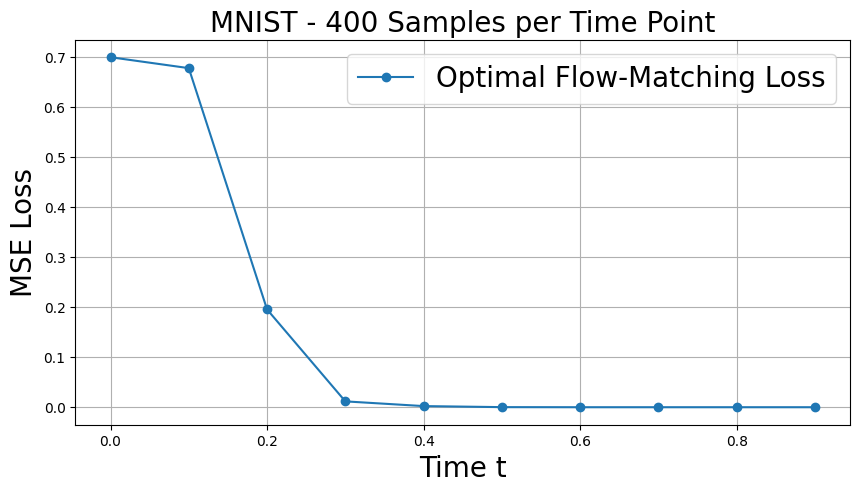

Average loss across all time points: 0.1586


In [18]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(time_points, losses, 'o-', label='Optimal Flow-Matching Loss')
plt.xlabel('Time t', fontsize = 20)
plt.ylabel('MSE Loss', fontsize = 20)
plt.title(f'MNIST - {num_batches*batch_size} Samples per Time Point', fontsize = 20)
plt.grid(True)
plt.legend(fontsize = 20)
plt.savefig('results/Loss_MNIST.png')
plt.show()

print(f"Average loss across all time points: {np.mean(losses):.4f}")